In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

class layer:
    def __init__(self, in_size, out_size):
#         self.W = tf.Variable(tf.zeros([in_size, out_size]))
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.01))
#         self.b = tf.Variable(tf.zeros([1,out_size]))
#         self.b = tf.Variable(tf.constant(0.1, shape=[1,out_size]))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.01))
    
        
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)
        
def weight_variable(shape):
    '''Helper function to create a weight variable initialized with
    a normal distribution

    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    '''Helper function to create a bias variable initialized with
    a constant value.

    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

In [4]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])

In [5]:
# d_l1 = layer(784, g_dim)
# d_l2 = layer(g_dim, 1)
# d_l3 = layer(g_dim, 1)

# g_l1 = layer(g_dim, 256)
# g_l2 = layer(256, 784)

# var_d = [d_l1.W, d_l1.b, d_l2.W, d_l2.b]
# var_g = [g_l1.W, g_l1.b, g_l2.W, g_l2.b]


weights = {
    "w_d1" : weight_variable([5, 5, 1, 32]),
    "w_d2" : weight_variable([5, 5, 32, 64]),
    "w_d3" : weight_variable([7 * 7 * 64, 1]),
    
    "w_g1" : weight_variable([g_dim, 4 * 4 * 64]),
    "w_g2" : weight_variable([5, 5, 32, 64]),
    "w_g3" : weight_variable([5, 5, 16, 32]),
    "w_g4" : weight_variable([5, 5, 1, 16])
}

biases = {
    "b_d1" : bias_variable([32]),
    "b_d2" : bias_variable([64]),
    "b_d3" : bias_variable([1]),
    "b_g1" : bias_variable([4 * 4 * 64]),
    "b_g2" : bias_variable([32]),
    "b_g3" : bias_variable([16]),
    "b_g4" : bias_variable([1]),
}

var_d = [weights["w_d1"], weights["w_d2"], weights["w_d3"], biases["b_d1"], biases["b_d2"], biases["b_d3"]]
var_g = [weights["w_g1"], weights["w_g2"],weights["w_g3"], weights["w_g4"], biases["b_g1"], biases["b_g2"],biases["b_g3"], biases["b_g4"]]

In [6]:
def generator(z):
    #100 x 1
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    #-1 x 4*4*128
    h_g1_reshape = tf.reshape(h_g1, [-1, 4, 4, 64])
    
    output_shape_g2 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_g2 = tf.nn.relu(tf.add(deconv2d(h_g1_reshape, weights["w_g2"], output_shape_g2), biases["b_g2"]))
    
    output_shape_g3 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_g3 = tf.nn.relu(tf.add(deconv2d(h_g2, weights["w_g3"], output_shape_g3), biases["b_g3"]))
    
    output_shape_g4 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_g4 = tf.nn.tanh(tf.add(deconv2d(h_g3, weights["w_g4"], output_shape_g4), biases["b_g4"]))
    
    return h_g4


def discriminator(x):
    x_reshape = tf.reshape(x, [-1, 28, 28, 1])
    # 28 x 28 x 1
    h_d1 = tf.nn.relu(tf.add(conv2d(x_reshape, weights["w_d1"]), biases["b_d1"]))
    # 14 x 14 x 32
    h_d2 = tf.nn.relu(tf.add(conv2d(h_d1, weights["w_d2"]), biases["b_d2"]))
    # 7 x 7 x 64
    h_d2_reshape = tf.reshape(h_d2, [-1, 7 * 7 * 64])
    h_d3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d2_reshape, weights["w_d3"]), biases["b_d3"]))
    return h_d3

In [7]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

g_sample = generator(x_g)
d_real= discriminator(x_d)
d_fake = discriminator(g_sample)

d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))
g_loss = -tf.reduce_mean(tf.log(d_fake))

# 只更新 discriminator
d_optimizer = tf.train.AdamOptimizer(0.00003).minimize(d_loss, var_list= var_d)
# d_optimizer = tf.train.MomentumOptimizer(0.01,0.01).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.AdamOptimizer(0.00003).minimize(g_loss, var_list= var_g)
# g_optimizer = tf.train.MomentumOptimizer(0.03,0.03).minimize(g_loss, var_list= var_g)


step: 0  d-loss: 1.38658  g-loss: 0.69293
step: 1000  d-loss: 0.727437  g-loss: 1.1241
step: 2000  d-loss: 0.254181  g-loss: 2.28391
step: 3000  d-loss: 0.141872  g-loss: 2.73206
step: 4000  d-loss: 0.132488  g-loss: 2.95816
step: 5000  d-loss: 0.112805  g-loss: 3.10349
step: 6000  d-loss: 0.0894997  g-loss: 3.32085
step: 7000  d-loss: 0.140774  g-loss: 3.34202
step: 8000  d-loss: 0.112723  g-loss: 3.14652
step: 9000  d-loss: 0.154474  g-loss: 3.16956
step: 10000  d-loss: 0.142971  g-loss: 3.79031
step: 11000  d-loss: 0.0745606  g-loss: 3.97225
step: 12000  d-loss: 0.094504  g-loss: 3.69866
step: 13000  d-loss: 0.0469137  g-loss: 3.92904
step: 14000  d-loss: 0.0598589  g-loss: 4.64844
step: 15000  d-loss: 0.064936  g-loss: 4.125
step: 16000  d-loss: 0.188164  g-loss: 4.32235
step: 17000  d-loss: 0.0940641  g-loss: 4.122
step: 18000  d-loss: 0.0688418  g-loss: 4.80993
step: 19000  d-loss: 0.124698  g-loss: 3.30901
step: 20000  d-loss: 0.058478  g-loss: 3.8389


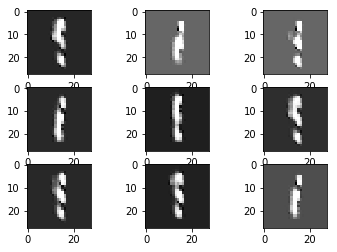

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')


step: 0  d-loss: 0.0652781  g-loss: 3.70442
step: 1000  d-loss: 0.101472  g-loss: 3.802
step: 2000  d-loss: 0.0976188  g-loss: 3.64884
step: 3000  d-loss: 0.13491  g-loss: 3.4184
step: 4000  d-loss: 0.180949  g-loss: 2.885
step: 5000  d-loss: 0.145208  g-loss: 3.48512
step: 6000  d-loss: 0.12547  g-loss: 3.3388
step: 7000  d-loss: 0.197949  g-loss: 3.6131
step: 8000  d-loss: 0.172171  g-loss: 3.76629
step: 9000  d-loss: 0.21467  g-loss: 3.33019
step: 10000  d-loss: 0.156124  g-loss: 3.67756
step: 11000  d-loss: 0.173194  g-loss: 3.73381
step: 12000  d-loss: 0.0889251  g-loss: 3.89254
step: 13000  d-loss: 0.18757  g-loss: 3.98595
step: 14000  d-loss: 0.103828  g-loss: 3.70742
step: 15000  d-loss: 0.132436  g-loss: 4.00834
step: 16000  d-loss: 0.0710782  g-loss: 4.12743
step: 17000  d-loss: 0.092977  g-loss: 3.97463
step: 18000  d-loss: 0.121231  g-loss: 3.97694
step: 19000  d-loss: 0.144772  g-loss: 2.97248
step: 20000  d-loss: 0.159108  g-loss: 3.39725


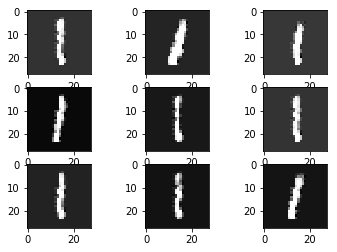

In [9]:
for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.112318  g-loss: 3.36565
step: 1000  d-loss: 0.133597  g-loss: 3.32364
step: 2000  d-loss: 0.103221  g-loss: 3.54017
step: 3000  d-loss: 0.162881  g-loss: 3.63907
step: 4000  d-loss: 0.18095  g-loss: 3.45525
step: 5000  d-loss: 0.202069  g-loss: 3.52167
step: 6000  d-loss: 0.0956659  g-loss: 3.66932
step: 7000  d-loss: 0.191393  g-loss: 3.53324
step: 8000  d-loss: 0.0665845  g-loss: 4.22034
step: 9000  d-loss: 0.121221  g-loss: 3.59487
step: 10000  d-loss: 0.107485  g-loss: 3.26239
step: 11000  d-loss: 0.107884  g-loss: 4.0185
step: 12000  d-loss: 0.107405  g-loss: 3.60391
step: 13000  d-loss: 0.0983389  g-loss: 3.9518
step: 14000  d-loss: 0.102862  g-loss: 3.69247
step: 15000  d-loss: 0.118189  g-loss: 3.36628
step: 16000  d-loss: 0.113748  g-loss: 3.79467
step: 17000  d-loss: 0.106863  g-loss: 3.53277
step: 18000  d-loss: 0.0676083  g-loss: 3.69874
step: 19000  d-loss: 0.0803655  g-loss: 3.73168
step: 20000  d-loss: 0.10984  g-loss: 4.18382


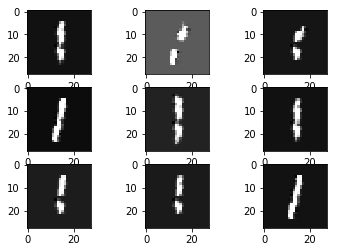

In [10]:
for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [11]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.109661  g-loss: 4.15624
step: 1000  d-loss: 0.125989  g-loss: 3.60261
step: 2000  d-loss: 0.147109  g-loss: 3.50244
step: 3000  d-loss: 0.129934  g-loss: 3.98851
step: 4000  d-loss: 0.131148  g-loss: 3.89519
step: 5000  d-loss: 0.0652589  g-loss: 4.23736
step: 6000  d-loss: 0.0419222  g-loss: 4.20027
step: 7000  d-loss: 0.163563  g-loss: 3.97354
step: 8000  d-loss: 0.104842  g-loss: 4.3316
step: 9000  d-loss: 0.182885  g-loss: 4.13116
step: 10000  d-loss: 0.150188  g-loss: 3.96692
step: 11000  d-loss: 0.167049  g-loss: 3.47733
step: 12000  d-loss: 0.0879142  g-loss: 3.62418
step: 13000  d-loss: 0.0782774  g-loss: 4.08558
step: 14000  d-loss: 0.122617  g-loss: 3.85829
step: 15000  d-loss: 0.0640874  g-loss: 3.37748
step: 16000  d-loss: 0.0756933  g-loss: 3.94407
step: 17000  d-loss: 0.140767  g-loss: 3.76788
step: 18000  d-loss: 0.0981265  g-loss: 3.86564
step: 19000  d-loss: 0.134931  g-loss: 3.98065
step: 20000  d-loss: 0.133125  g-loss: 3.86673
step: 21000  d-loss:

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [12]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: nan  g-loss: nan
step: 1000  d-loss: nan  g-loss: nan
step: 2000  d-loss: nan  g-loss: nan
step: 3000  d-loss: nan  g-loss: nan
step: 4000  d-loss: nan  g-loss: nan
step: 5000  d-loss: nan  g-loss: nan
step: 6000  d-loss: nan  g-loss: nan
step: 7000  d-loss: nan  g-loss: nan
step: 8000  d-loss: nan  g-loss: nan
step: 9000  d-loss: nan  g-loss: nan
step: 10000  d-loss: nan  g-loss: nan
step: 11000  d-loss: nan  g-loss: nan
step: 12000  d-loss: nan  g-loss: nan
step: 13000  d-loss: nan  g-loss: nan
step: 14000  d-loss: nan  g-loss: nan
step: 15000  d-loss: nan  g-loss: nan
step: 16000  d-loss: nan  g-loss: nan
step: 17000  d-loss: nan  g-loss: nan
step: 18000  d-loss: nan  g-loss: nan
step: 19000  d-loss: nan  g-loss: nan
step: 20000  d-loss: nan  g-loss: nan
step: 21000  d-loss: nan  g-loss: nan
step: 22000  d-loss: nan  g-loss: nan
step: 23000  d-loss: nan  g-loss: nan
step: 24000  d-loss: nan  g-loss: nan
step: 25000  d-loss: nan  g-loss: nan
step: 26000  d-loss: nan 

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [13]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: nan  g-loss: nan
step: 1000  d-loss: nan  g-loss: nan
step: 2000  d-loss: nan  g-loss: nan
step: 3000  d-loss: nan  g-loss: nan
step: 4000  d-loss: nan  g-loss: nan
step: 5000  d-loss: nan  g-loss: nan
step: 6000  d-loss: nan  g-loss: nan
step: 7000  d-loss: nan  g-loss: nan
step: 8000  d-loss: nan  g-loss: nan
step: 9000  d-loss: nan  g-loss: nan
step: 10000  d-loss: nan  g-loss: nan
step: 11000  d-loss: nan  g-loss: nan
step: 12000  d-loss: nan  g-loss: nan
step: 13000  d-loss: nan  g-loss: nan
step: 14000  d-loss: nan  g-loss: nan
step: 15000  d-loss: nan  g-loss: nan
step: 16000  d-loss: nan  g-loss: nan
step: 17000  d-loss: nan  g-loss: nan
step: 18000  d-loss: nan  g-loss: nan
step: 19000  d-loss: nan  g-loss: nan
step: 20000  d-loss: nan  g-loss: nan
step: 21000  d-loss: nan  g-loss: nan
step: 22000  d-loss: nan  g-loss: nan
step: 23000  d-loss: nan  g-loss: nan
step: 24000  d-loss: nan  g-loss: nan
step: 25000  d-loss: nan  g-loss: nan
step: 26000  d-loss: nan 

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [14]:
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'